# Yield Curve interpolation 
### using cubic spline and Nelson_Siegel model

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta
from scipy.interpolate import CubicSpline
from scipy.optimize import least_squares

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = 15, 10

In [2]:
data = pd.read_excel('FIS_Project_Data/3.xlsx')
data = data[data.iloc[:, 6] != 'Same']
data.index = range(12)
data

,Tenor,Cusip,I1 Mid YTM AUD Australia Sovereign Curve 03/05/19 Description,I1 Mid YTM AUD Australia Sovereign Curve 03/05/19 Price,I1 Mid YTM AUD Australia Sovereign Curve 03/05/19 Yield,Cusip.1,I1 Mid YTM AUD Australia Sovereign Curve 12/03/18 Description,I1 Mid YTM AUD Australia Sovereign Curve 12/03/18 Price,I1 Mid YTM AUD Australia Sovereign Curve 12/03/18 Yield,I1 Mid YTM (Change) 03/05/19-12/03/18 Price,I1 Mid YTM (Change) 03/05/19-12/03/18 Yield,Coupons
0,3M,AX258590@BVAL Corp,ACTB 0 06/21/19 Corp,99.449,1.891,AU845225@BVAL Corp,ACTB 0 02/22/19 Corp,99.587,1.892,-0.138,0.0,0.00
1,1Y,EH807646@BCMP Corp,ACGB 4 ½ 04/15/20 Corp,102.979,1.769,EK382179@BCMP Corp,ACGB 2 ¾ 10/21/19 Corp,100.720,1.916,2.259,-14.7,2.75
2,2Y,EG821160@BCMP Corp,ACGB 5 ¾ 05/15/21 Corp,108.616,1.724,EK841545@BCMP Corp,ACGB 1 ¾ 11/21/20 Corp,99.521,2.000,9.095,-27.6,1.75
3,3Y,EI214281@BCMP Corp,ACGB 5 ¾ 07/15/22 Corp,113.305,1.661,EG821160@BCMP Corp,ACGB 5 ¾ 05/15/21 Corp,108.856,2.019,4.449,-35.8,5.75
4,4Y,EI683148@BCMP Corp,ACGB 5 ½ 04/21/23 Corp,115.173,1.676,AP364296@BCMP Corp,ACGB 2 ¼ 11/21/22 Corp,100.331,2.162,14.843,-48.6,2.25
5,5Y,EJ244569@BCMP Corp,ACGB 2 ¾ 04/21/24 Corp,104.809,1.764,EI683148@BCMP Corp,ACGB 5 ½ 04/21/23 Corp,113.695,2.200,-8.886,-43.6,5.50
6,6Y,EJ679130@BCMP Corp,ACGB 3 ¼ 04/21/25 Corp,107.938,1.872,EJ244569@BCMP Corp,ACGB 2 ¾ 04/21/24 Corp,102.180,2.316,5.758,-44.4,2.75
7,7Y,EK115060@BCMP Corp,ACGB 4 ¼ 04/21/26 Corp,115.128,1.963,EJ679130@BCMP Corp,ACGB 3 ¼ 04/21/25 Corp,104.958,2.406,10.170,-44.3,3.25
8,8Y,EI849265@BCMP Corp,ACGB 4 ¾ 04/21/27 Corp,120.167,2.043,EK115060@BCMP Corp,ACGB 4 ¼ 04/21/26 Corp,111.886,2.477,8.281,-43.4,4.25
9,9Y,LW020767@BCMP Corp,ACGB 2 ¼ 05/21/28 Corp,100.930,2.138,EI849265@BCMP Corp,ACGB 4 ¾ 04/21/27 Corp,116.603,2.537,-15.672,-39.9,4.75


In [3]:
def schedule(maturity_date, date_today):
    coupon_dates = []
    i = datetime.strptime(maturity_date, '%m/%d/%y')
    while (i >= datetime.strptime(date_today, '%m/%d/%y')):
        coupon_dates.append(i)
        i = i - relativedelta(months=+6)
    return np.flip(coupon_dates, 0)

In [4]:
def Get_Input_Data(data, date_today):
    prices_data = data.ix[:, 7].values
    coupons = data.ix[:, -1].values
    
    X_values = []
    Y_values = []
    coupon_schedule_all_bonds = []
    for j in data.index:
        i = data.ix[:, 6].str.split()[j]
        X_values.append((datetime.strptime(i[-2], '%m/%d/%y') - datetime.strptime(date_today, '%m/%d/%y')).days)
        Y_values.append(data.ix[:, 8][j])
        coupon_schedule_all_bonds.append(schedule(i[-2], date_today))
    
    time_T = np.round(np.array(X_values)*12/365, 3)
    yields = np.array(Y_values)
    
    return time_T, yields, coupon_schedule_all_bonds, prices_data, coupons

In [5]:
date_today = '12/03/18'
time_T, yields, coupon_schedule_all_bonds, prices_data, coupons = Get_Input_Data(data, date_today)

In [6]:
time_T
yields
coupon_schedule_all_bonds
prices_data
coupons;

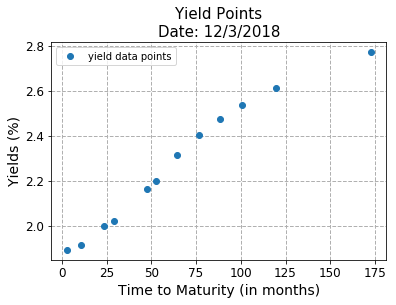

In [8]:
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(time_T, yields, 'o', label = 'yield data points')
plt.title('Yield Points\nDate: 12/3/2018', fontsize = 15)
plt.legend()
plt.grid(linestyle = '--', linewidth = 1)

#### Cubic Spline

In [9]:
cs = CubicSpline(time_T, yields)
curve_points = np.linspace(min(time_T), max(time_T), 1000)

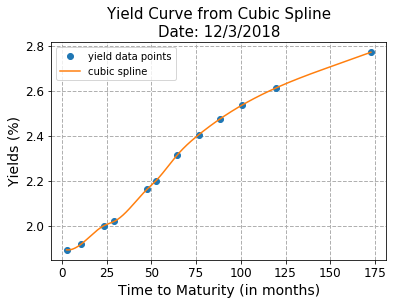

In [10]:
plt.figure()
plt.title('Yield Curve from Cubic Spline\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(time_T, yields, 'o', label = 'yield data points')
plt.plot(curve_points, cs(curve_points), label="cubic spline")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

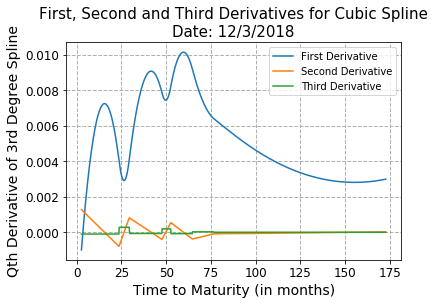

In [11]:
plt.figure()
plt.title('First, Second and Third Derivatives for Cubic Spline\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Qth Derivative of 3rd Degree Spline')
plt.plot(curve_points, cs(curve_points, 1), label="First Derivative")
plt.plot(curve_points, cs(curve_points, 2), label="Second Derivative")
plt.plot(curve_points, cs(curve_points, 3), label="Third Derivative")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

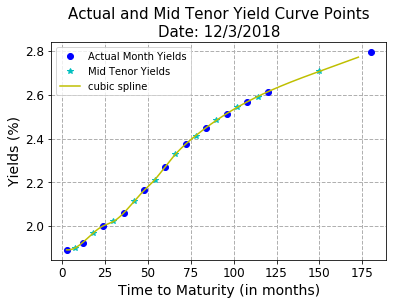

In [12]:
tenors = np.array([3/12*12, 1*12, 24, 3*12, 4*12, 5*12, 6*12, 7*12, 8*12, 9*12, 10*12, 15*12])
maturities_btw_each_tenors = np.array([7.5, 1.5*12, 2.5*12, 3.5*12, 4.5*12, 5.5*12, 6.5*12, 7.5*12, 8.5*12, 9.5*12, 12.5*12])

plt.figure()
plt.title('Actual and Mid Tenor Yield Curve Points\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(tenors, cs(tenors), 'o', color = 'b', label = 'Actual Month Yields')
plt.plot(maturities_btw_each_tenors, cs(maturities_btw_each_tenors), '*', color = 'c', label="Mid Tenor Yields")
plt.plot(curve_points, cs(curve_points), color = 'y', label="cubic spline")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

In [13]:
yield_values_for_each_tenors = pd.DataFrame({'Tenors (months)': tenors, 'Actual Month Yields': cs(tenors)})
yield_values_for_mid_tenors = pd.DataFrame({'Mid Tenors (months)': maturities_btw_each_tenors, 'Mid Tenor Yields': cs(maturities_btw_each_tenors)})

In [14]:
yield_values_for_each_tenors

,Tenors (months),Actual Month Yields
0,3.0,1.891737
1,12.0,1.924958
2,24.0,2.001415
3,36.0,2.060700
4,48.0,2.164824
5,60.0,2.270528
6,72.0,2.375010
7,84.0,2.450936
8,96.0,2.515029
9,108.0,2.569083


In [15]:
yield_values_for_mid_tenors

,Mid Tenors (months),Mid Tenor Yields
0,7.5,1.900260
1,18.0,1.967484
2,30.0,2.021643
3,42.0,2.113232
4,54.0,2.211983
5,66.0,2.328199
6,78.0,2.414657
7,90.0,2.484349
8,102.0,2.543194
9,114.0,2.592951


In [16]:
yield_values_for_each_tenors.join(yield_values_for_mid_tenors)

,Tenors (months),Actual Month Yields,Mid Tenors (months),Mid Tenor Yields
0,3.0,1.891737,7.5,1.900260
1,12.0,1.924958,18.0,1.967484
2,24.0,2.001415,30.0,2.021643
3,36.0,2.060700,42.0,2.113232
4,48.0,2.164824,54.0,2.211983
5,60.0,2.270528,66.0,2.328199
6,72.0,2.375010,78.0,2.414657
7,84.0,2.450936,90.0,2.484349
8,96.0,2.515029,102.0,2.543194
9,108.0,2.569083,114.0,2.592951


			********  RESULTS FOR DATE: 12/1/18  ********


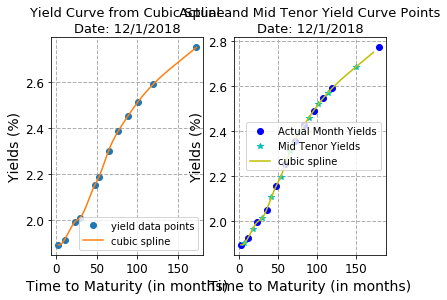

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.892682                7.5          1.899664
1            12.0             1.923237               18.0          1.964053
2            24.0             1.994950               30.0          2.011125
3            36.0             2.049939               42.0          2.103817
4            48.0             2.154115               54.0          2.196678
5            60.0             2.254505               66.0          2.312544
6            72.0             2.357766               78.0          2.394589
7            84.0             2.428057               90.0          2.459775
8            96.0             2.490320              102.0          2.519015
9           108.0             2.545353              114.0          2.569528
10          120.0             2.591823              150.0          2.685061
11          180.0             2.773932                NaN               NaN


			*******

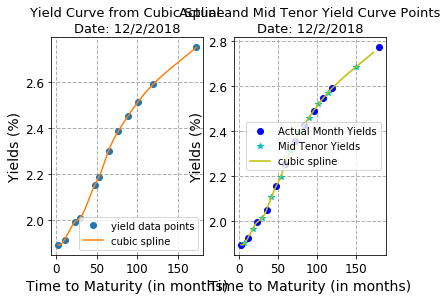

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.892650                7.5          1.899788
1            12.0             1.923448               18.0          1.964271
2            24.0             1.995051               30.0          2.011263
3            36.0             2.050214               42.0          2.104124
4            48.0             2.154347               54.0          2.196948
5            60.0             2.254837               66.0          2.312829
6            72.0             2.357987               78.0          2.394780
7            84.0             2.428235               90.0          2.459947
8            96.0             2.490483              102.0          2.519166
9           108.0             2.545491              114.0          2.569655
10          120.0             2.591941              150.0          2.685155
11          180.0             2.774040                NaN               NaN


			*******

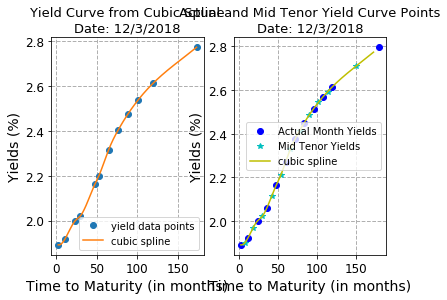

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.891737                7.5          1.900260
1            12.0             1.924958               18.0          1.967484
2            24.0             2.001415               30.0          2.021643
3            36.0             2.060700               42.0          2.113232
4            48.0             2.164824               54.0          2.211983
5            60.0             2.270528               66.0          2.328199
6            72.0             2.375010               78.0          2.414657
7            84.0             2.450936               90.0          2.484349
8            96.0             2.515029              102.0          2.543194
9           108.0             2.569083              114.0          2.592951
10          120.0             2.615053              150.0          2.708074
11          180.0             2.795478                NaN               NaN


			*******

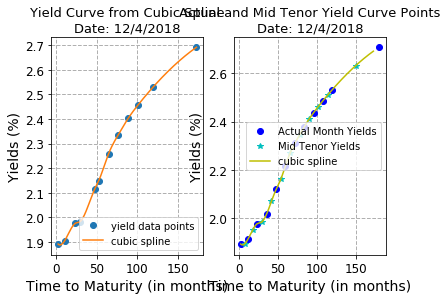

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.889914                7.5          1.891363
1            12.0             1.912073               18.0          1.950172
2            24.0             1.975776               30.0          1.983708
3            36.0             2.017139               42.0          2.068359
4            48.0             2.117817               54.0          2.160271
5            60.0             2.215725               66.0          2.269270
6            72.0             2.309648               78.0          2.343899
7            84.0             2.377619               90.0          2.408937
8            96.0             2.436489              102.0          2.461783
9           108.0             2.486108              114.0          2.509591
10          120.0             2.532218              150.0          2.632041
11          180.0             2.708404                NaN               NaN


			*******

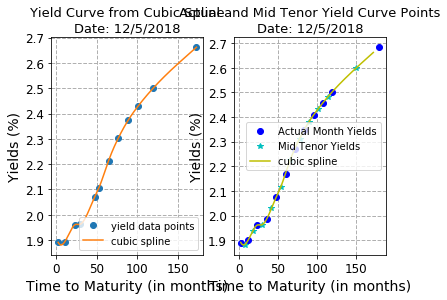

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.888728                7.5          1.881953
1            12.0             1.899679               18.0          1.937523
2            24.0             1.961564               30.0          1.962839
3            36.0             1.986739               42.0          2.029048
4            48.0             2.073948               54.0          2.116417
5            60.0             2.170518               66.0          2.225396
6            72.0             2.271960               78.0          2.312181
7            84.0             2.348266               90.0          2.380236
8            96.0             2.408363              102.0          2.433937
9           108.0             2.457976              114.0          2.480708
10          120.0             2.502270              150.0          2.597237
11          180.0             2.683171                NaN               NaN


			*******

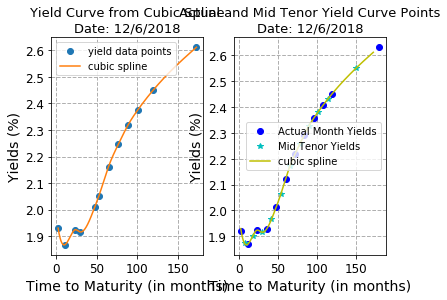

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.921855                7.5          1.872354
1            12.0             1.870137               18.0          1.901821
2            24.0             1.924184               30.0          1.915540
3            36.0             1.929236               42.0          1.965724
4            48.0             2.012695               54.0          2.063446
5            60.0             2.120700               66.0          2.173986
6            72.0             2.216967               78.0          2.255274
7            84.0             2.292732               90.0          2.326841
8            96.0             2.356060              102.0          2.382210
9           108.0             2.406847              114.0          2.430221
10          120.0             2.452428              150.0          2.549340
11          180.0             2.631565                NaN               NaN


			*******

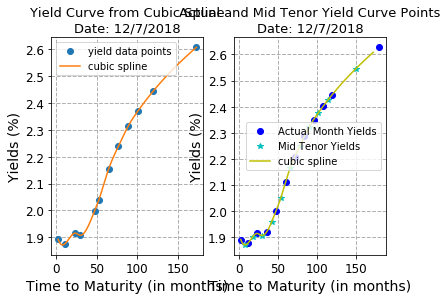

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.888299                7.5          1.871219
1            12.0             1.878352               18.0          1.902582
2            24.0             1.914802               30.0          1.906795
3            36.0             1.921797               42.0          1.957840
4            48.0             2.002731               54.0          2.051605
5            60.0             2.110374               66.0          2.165593
6            72.0             2.209001               78.0          2.247654
7            84.0             2.286196               90.0          2.321150
8            96.0             2.350401              102.0          2.376293
9           108.0             2.400807              114.0          2.424206
10          120.0             2.446558              150.0          2.544981
11          180.0             2.627372                NaN               NaN


			*******

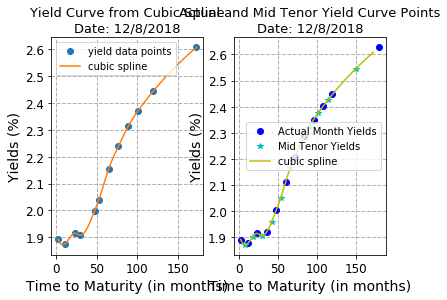

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.888054                7.5          1.871200
1            12.0             1.878461               18.0          1.902711
2            24.0             1.914780               30.0          1.906797
3            36.0             1.921949               42.0          1.958074
4            48.0             2.002981               54.0          2.051909
5            60.0             2.110702               66.0          2.165860
6            72.0             2.209218               78.0          2.247868
7            84.0             2.286402               90.0          2.321325
8            96.0             2.350550              102.0          2.376431
9           108.0             2.400938              114.0          2.424331
10          120.0             2.446678              150.0          2.545079
11          180.0             2.627456                NaN               NaN


			*******

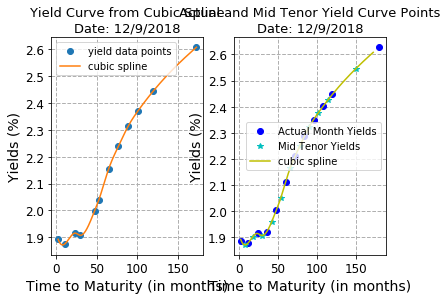

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.887810                7.5          1.871182
1            12.0             1.878570               18.0          1.902839
2            24.0             1.914757               30.0          1.906802
3            36.0             1.922100               42.0          1.958307
4            48.0             2.003230               54.0          2.052213
5            60.0             2.111030               66.0          2.166128
6            72.0             2.209436               78.0          2.248081
7            84.0             2.286608               90.0          2.321500
8            96.0             2.350699              102.0          2.376569
9           108.0             2.401070              114.0          2.424457
10          120.0             2.446798              150.0          2.545177
11          180.0             2.627541                NaN               NaN


			*******

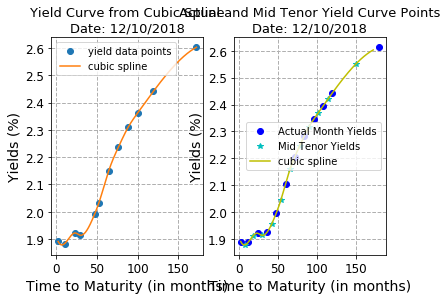

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.887873                7.5          1.878367
1            12.0             1.888047               18.0          1.911264
2            24.0             1.921723               30.0          1.913559
3            36.0             1.924667               42.0          1.954985
4            48.0             1.996345               54.0          2.045717
5            60.0             2.105416               66.0          2.161841
6            72.0             2.206877               78.0          2.246341
7            84.0             2.284032               90.0          2.317188
8            96.0             2.344652              102.0          2.369574
9           108.0             2.394316              114.0          2.418901
10          120.0             2.443100              150.0          2.550209
11          180.0             2.613018                NaN               NaN


			*******

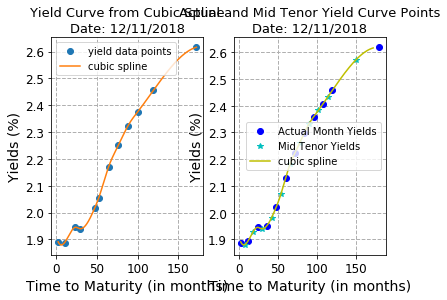

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.887616                7.5          1.880289
1            12.0             1.895432               18.0          1.927744
2            24.0             1.945222               30.0          1.939764
3            36.0             1.951552               42.0          1.981316
4            48.0             2.021443               54.0          2.069863
5            60.0             2.129118               66.0          2.183147
6            72.0             2.223566               78.0          2.260190
7            84.0             2.298477               90.0          2.332363
8            96.0             2.358787              102.0          2.382445
9           108.0             2.406881              114.0          2.432010
10          120.0             2.457358              150.0          2.570794
11          180.0             2.618615                NaN               NaN


			*******

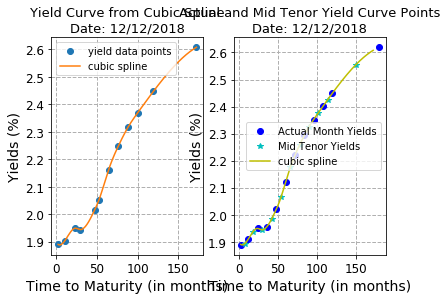

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.888916                7.5          1.892522
1            12.0             1.909380               18.0          1.936530
2            24.0             1.948993               30.0          1.943886
3            36.0             1.955681               42.0          1.983706
4            48.0             2.020178               54.0          2.063894
5            60.0             2.120208               66.0          2.175183
6            72.0             2.219835               78.0          2.258346
7            84.0             2.293857               90.0          2.325146
8            96.0             2.351993              102.0          2.376813
9           108.0             2.401340              114.0          2.425569
10          120.0             2.449316              150.0          2.554320
11          180.0             2.619439                NaN               NaN


			*******

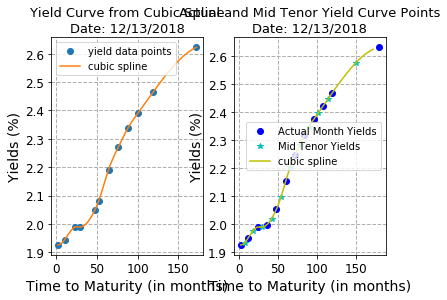

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.926084                7.5          1.934280
1            12.0             1.951146               18.0          1.975980
2            24.0             1.989503               30.0          1.989246
3            36.0             1.998508               42.0          2.019994
4            48.0             2.052205               54.0          2.096322
5            60.0             2.152122               66.0          2.204525
6            72.0             2.245259               78.0          2.281055
7            84.0             2.316073               90.0          2.347165
8            96.0             2.372976              102.0          2.396677
9           108.0             2.420575              114.0          2.444607
10          120.0             2.468469              150.0          2.574493
11          180.0             2.630326                NaN               NaN


			*******

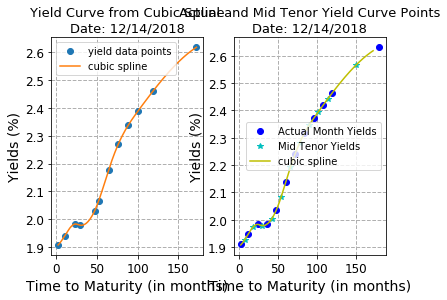

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.910050                7.5          1.927421
1            12.0             1.948362               18.0          1.973055
2            24.0             1.983036               30.0          1.978560
3            36.0             1.983825               42.0          2.002857
4            48.0             2.035688               54.0          2.081737
5            60.0             2.136496               66.0          2.191226
6            72.0             2.239762               78.0          2.281155
7            84.0             2.315705               90.0          2.344982
8            96.0             2.370750              102.0          2.394879
9           108.0             2.418564              114.0          2.441798
10          120.0             2.464452              150.0          2.564529
11          180.0             2.630829                NaN               NaN


			*******

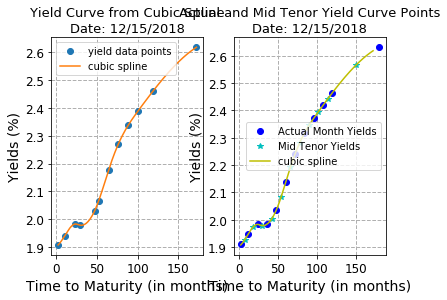

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.910152                7.5          1.927568
1            12.0             1.948516               18.0          1.973161
2            24.0             1.983030               30.0          1.978552
3            36.0             1.983892               42.0          2.003000
4            48.0             2.035906               54.0          2.082022
5            60.0             2.136806               66.0          2.191512
6            72.0             2.240010               78.0          2.281363
7            84.0             2.315879               90.0          2.345131
8            96.0             2.370885              102.0          2.395010
9           108.0             2.418692              114.0          2.441922
10          120.0             2.464571              150.0          2.564615
11          180.0             2.630885                NaN               NaN


			*******

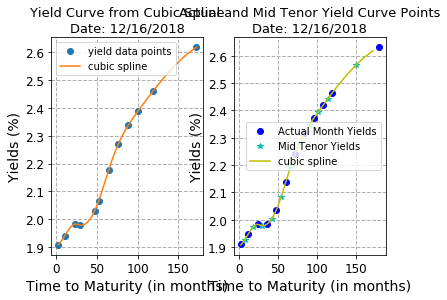

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.910253                7.5          1.927714
1            12.0             1.948670               18.0          1.973267
2            24.0             1.983023               30.0          1.978544
3            36.0             1.983960               42.0          2.003143
4            48.0             2.036125               54.0          2.082307
5            60.0             2.137115               66.0          2.191797
6            72.0             2.240257               78.0          2.281570
7            84.0             2.316052               90.0          2.345281
8            96.0             2.371021              102.0          2.395141
9           108.0             2.418821              114.0          2.442048
10          120.0             2.464694              150.0          2.564709
11          180.0             2.630933                NaN               NaN


			*******

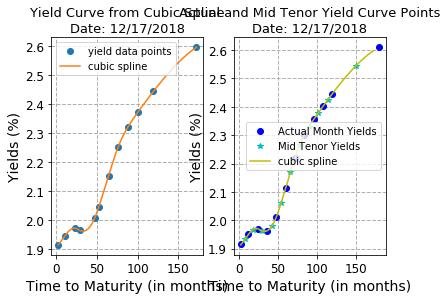

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.915744                7.5          1.932778
1            12.0             1.949946               18.0          1.967121
2            24.0             1.970330               30.0          1.961797
3            36.0             1.962769               42.0          1.978590
4            48.0             2.011624               54.0          2.059837
5            60.0             2.113637               66.0          2.168627
6            72.0             2.220781               78.0          2.265606
7            84.0             2.301247               90.0          2.330335
8            96.0             2.355579              102.0          2.379081
9           108.0             2.402125              114.0          2.424716
10          120.0             2.446740              150.0          2.544276
11          180.0             2.610221                NaN               NaN


			*******

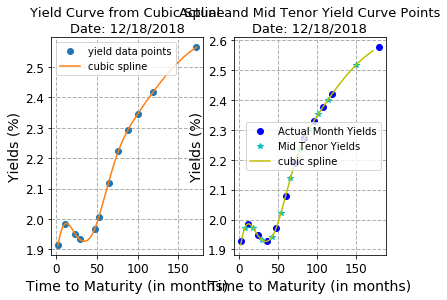

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.927527                7.5          1.972221
1            12.0             1.985443               18.0          1.972492
2            24.0             1.947686               30.0          1.930825
3            36.0             1.927437               42.0          1.940490
4            48.0             1.972906               54.0          2.022909
5            60.0             2.079957               66.0          2.137534
6            72.0             2.190668               78.0          2.236050
7            84.0             2.272632               90.0          2.302834
8            96.0             2.329112              102.0          2.353432
9           108.0             2.376999              114.0          2.399834
10          120.0             2.421844              150.0          2.516382
11          180.0             2.576772                NaN               NaN


			*******

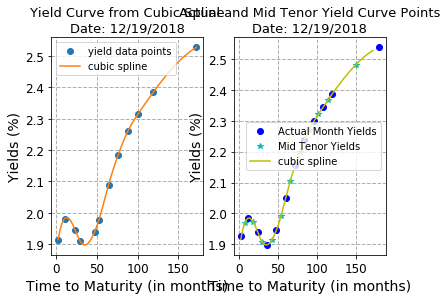

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.926921                7.5          1.969576
1            12.0             1.984423               18.0          1.972617
2            24.0             1.939357               30.0          1.906381
3            36.0             1.898114               42.0          1.913056
4            48.0             1.945748               54.0          1.992518
5            60.0             2.049581               66.0          2.106066
6            72.0             2.155444               78.0          2.199394
7            84.0             2.238707               90.0          2.271526
8            96.0             2.297884              102.0          2.321262
9           108.0             2.344044              114.0          2.366307
10          120.0             2.387917              150.0          2.481438
11          180.0             2.538386                NaN               NaN


			*******

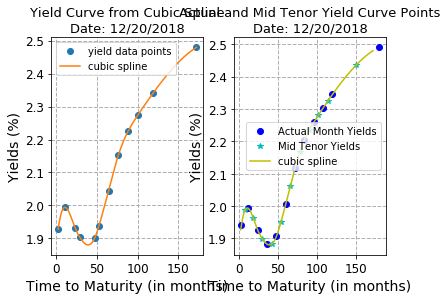

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.941828                7.5          1.986750
1            12.0             1.992735               18.0          1.964542
2            24.0             1.925653               30.0          1.898543
3            36.0             1.882431               42.0          1.882758
4            48.0             1.906406               54.0          1.952290
5            60.0             2.006351               66.0          2.063309
6            72.0             2.118428               78.0          2.166187
7            84.0             2.203963               90.0          2.233899
8            96.0             2.258670              102.0          2.281097
9           108.0             2.302942              114.0          2.324247
10          120.0             2.344899              150.0          2.434430
11          180.0             2.490755                NaN               NaN


			*******

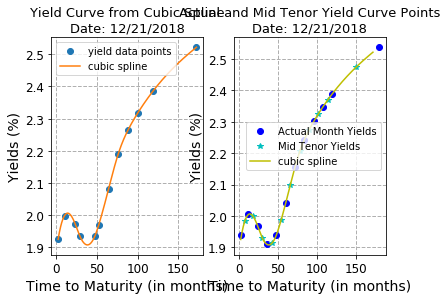

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.938450                7.5          1.985060
1            12.0             2.004837               18.0          1.998633
2            24.0             1.966749               30.0          1.928438
3            36.0             1.909057               42.0          1.912633
4            48.0             1.939946               54.0          1.986793
5            60.0             2.041779               66.0          2.100145
6            72.0             2.156909               78.0          2.205625
7            84.0             2.243644               90.0          2.274528
8            96.0             2.301388              102.0          2.325748
9           108.0             2.348521              114.0          2.369867
10          120.0             2.389882              150.0          2.473326
11          180.0             2.537779                NaN               NaN


			*******

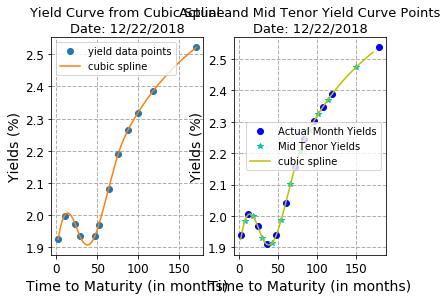

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.938902                7.5          1.985296
1            12.0             2.004896               18.0          1.998517
2            24.0             1.966528               30.0          1.928270
3            36.0             1.909013               42.0          1.912718
4            48.0             1.940162               54.0          1.987079
5            60.0             2.042094               66.0          2.100467
6            72.0             2.157205               78.0          2.205861
7            84.0             2.243830               90.0          2.274685
8            96.0             2.301527              102.0          2.325877
9           108.0             2.348642              114.0          2.369980
10          120.0             2.389989              150.0          2.473405
11          180.0             2.537844                NaN               NaN


			*******

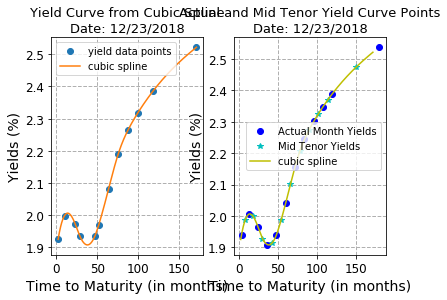

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.939353                7.5          1.985531
1            12.0             2.004954               18.0          1.998399
2            24.0             1.966306               30.0          1.928103
3            36.0             1.908970               42.0          1.912803
4            48.0             1.940379               54.0          1.987365
5            60.0             2.042410               66.0          2.100789
6            72.0             2.157501               78.0          2.206096
7            84.0             2.244015               90.0          2.274842
8            96.0             2.301667              102.0          2.326007
9           108.0             2.348762              114.0          2.370092
10          120.0             2.390092              150.0          2.473476
11          180.0             2.537915                NaN               NaN


			*******

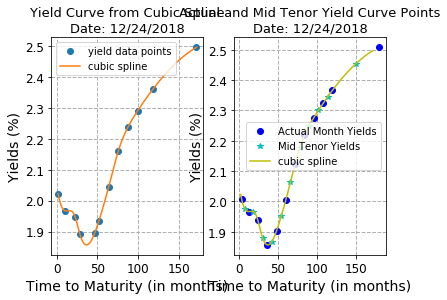

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.009297                7.5          1.974354
1            12.0             1.966561               18.0          1.966478
2            24.0             1.938182               30.0          1.880418
3            36.0             1.856899               42.0          1.867598
4            48.0             1.902397               54.0          1.950551
5            60.0             2.004546               66.0          2.063912
6            72.0             2.124820               78.0          2.177556
7            84.0             2.217617               90.0          2.249117
8            96.0             2.275876              102.0          2.300170
9           108.0             2.323319              114.0          2.345397
10          120.0             2.366369              150.0          2.453514
11          180.0             2.508140                NaN               NaN


			*******

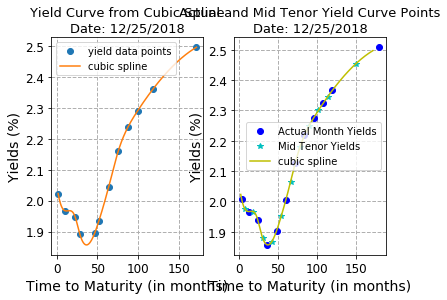

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.008898                7.5          1.974221
1            12.0             1.966559               18.0          1.966439
2            24.0             1.937880               30.0          1.880176
3            36.0             1.856874               42.0          1.867733
4            48.0             1.902636               54.0          1.950833
5            60.0             2.004858               66.0          2.064250
6            72.0             2.125141               78.0          2.177808
7            84.0             2.217809               90.0          2.249274
8            96.0             2.276014              102.0          2.300300
9           108.0             2.323444              114.0          2.345515
10          120.0             2.366481              150.0          2.453592
11          180.0             2.508181                NaN               NaN


			*******

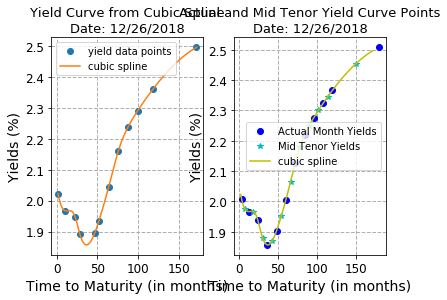

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.008501                7.5          1.974090
1            12.0             1.966555               18.0          1.966396
2            24.0             1.937579               30.0          1.879946
3            36.0             1.856860               42.0          1.867876
4            48.0             1.902873               54.0          1.951107
5            60.0             2.005166               66.0          2.064591
6            72.0             2.125463               78.0          2.178060
7            84.0             2.218001               90.0          2.249432
8            96.0             2.276153              102.0          2.300430
9           108.0             2.323568              114.0          2.345634
10          120.0             2.366594              150.0          2.453672
11          180.0             2.508221                NaN               NaN


			*******

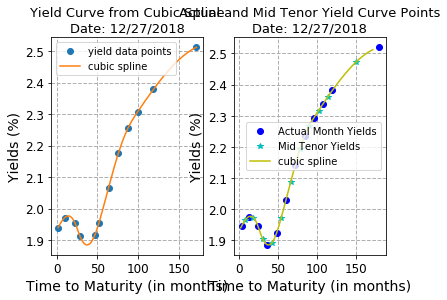

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.945580                7.5          1.964285
1            12.0             1.975197               18.0          1.972917
2            24.0             1.945564               30.0          1.904831
3            36.0             1.885735               42.0          1.891983
4            48.0             1.922749               54.0          1.972236
5            60.0             2.028671               66.0          2.086729
6            72.0             2.142265               78.0          2.191972
7            84.0             2.233703               90.0          2.266942
8            96.0             2.293101              102.0          2.316171
9           108.0             2.338649              114.0          2.360569
10          120.0             2.381775              150.0          2.471554
11          180.0             2.519797                NaN               NaN


			*******

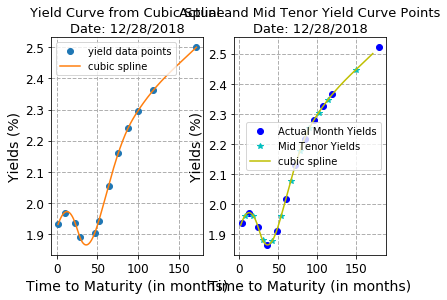

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.939258                7.5          1.962578
1            12.0             1.971814               18.0          1.961816
2            24.0             1.925890               30.0          1.881396
3            36.0             1.865040               42.0          1.876753
4            48.0             1.911403               54.0          1.961732
5            60.0             2.018415               66.0          2.075505
6            72.0             2.128888               78.0          2.176641
7            84.0             2.217613               90.0          2.251546
8            96.0             2.279360              102.0          2.303549
9           108.0             2.325775              114.0          2.346345
10          120.0             2.365461              150.0          2.446298
11          180.0             2.521084                NaN               NaN


			*******

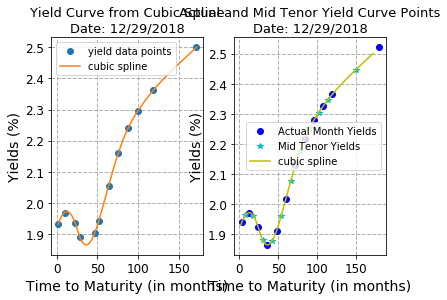

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.939478                7.5          1.962694
1            12.0             1.971829               18.0          1.961695
2            24.0             1.925633               30.0          1.881218
3            36.0             1.865024               42.0          1.876875
4            48.0             1.911642               54.0          1.962034
5            60.0             2.018734               66.0          2.075811
6            72.0             2.129168               78.0          2.176885
7            84.0             2.217819               90.0          2.251714
8            96.0             2.279501              102.0          2.303676
9           108.0             2.325893              114.0          2.346454
10          120.0             2.365562              150.0          2.446378
11          180.0             2.521169                NaN               NaN


			*******

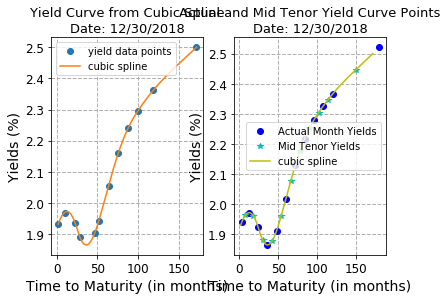

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.939699                7.5          1.962813
1            12.0             1.971844               18.0          1.961568
2            24.0             1.925368               30.0          1.881043
3            36.0             1.865017               42.0          1.877008
4            48.0             1.911886               54.0          1.962335
5            60.0             2.019052               66.0          2.076116
6            72.0             2.129447               78.0          2.177129
7            84.0             2.218025               90.0          2.251881
8            96.0             2.279641              102.0          2.303803
9           108.0             2.326010              114.0          2.346563
10          120.0             2.365664              150.0          2.446459
11          180.0             2.521257                NaN               NaN


			*******

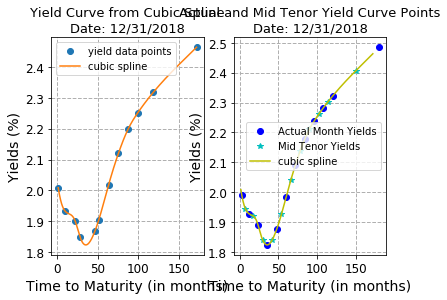

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.989446                7.5          1.945365
1            12.0             1.928786               18.0          1.920062
2            24.0             1.889902               30.0          1.839679
3            36.0             1.824191               42.0          1.840306
4            48.0             1.877044               54.0          1.926369
5            60.0             1.983442               66.0          2.039933
6            72.0             2.090992               78.0          2.136919
7            84.0             2.177396               90.0          2.210796
8            96.0             2.237471              102.0          2.260583
9           108.0             2.282188              114.0          2.302555
10          120.0             2.321823              150.0          2.406569
11          180.0             2.484772                NaN               NaN




In [17]:
days_DEC2018 = range(1,32)

for i in days_DEC2018:
    print('\t\t\t********  RESULTS FOR DATE: ' + '12/' + str(i) + '/18  ********')
    Dec_data = pd.read_excel('FIS_Project_Data/' + str(i) + '.xlsx')
    Dec_data = Dec_data[Dec_data.iloc[:, 6] != 'Same']
    Dec_data.index = range(12)
    
    Dec_date_today = '12/' + str(i) + '/18'
    Dec_time_T, Dec_yields, Dec_coupon_schedule_all_bonds, Dec_prices_data, Dec_coupons = Get_Input_Data(Dec_data, Dec_date_today)
    
    cs = CubicSpline(Dec_time_T, Dec_yields)
    curve_points = np.linspace(min(Dec_time_T), max(Dec_time_T), 1000)
    
    plt.subplot(1,2,1)
    plt.title('Yield Curve from Cubic Spline\nDate: 12/' + str(i) + '/2018', fontsize = 13)
    plt.xlabel('Time to Maturity (in months)')
    plt.ylabel('Yields (%)')
    plt.plot(Dec_time_T, Dec_yields, 'o', label = 'yield data points')
    plt.plot(curve_points, cs(curve_points), label="cubic spline")
    plt.grid(linestyle = '--', linewidth = 1)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Actual and Mid Tenor Yield Curve Points\nDate: 12/' + str(i) + '/2018', fontsize = 13)
    plt.xlabel('Time to Maturity (in months)')
    plt.ylabel('Yields (%)')
    plt.plot(tenors, cs(tenors), 'o', color = 'b', label = 'Actual Month Yields')
    plt.plot(maturities_btw_each_tenors, cs(maturities_btw_each_tenors), '*', color = 'c', label="Mid Tenor Yields")
    plt.plot(curve_points, cs(curve_points), color = 'y', label="cubic spline")
    plt.grid(linestyle = '--', linewidth = 1)
    plt.legend()
    plt.show()
    
    yield_values_for_each_tenors = pd.DataFrame({'Tenors(mnths)': tenors, 'Actual Month Yields': cs(tenors)})
    yield_values_for_mid_tenors = pd.DataFrame({'Mid Tenors(mnths)': maturities_btw_each_tenors, 'Mid Tenor Yields': cs(maturities_btw_each_tenors)})

    print(yield_values_for_each_tenors.join(yield_values_for_mid_tenors))
    print('\n')

#### Nelson Siegel

In [18]:
lamda = 0.0605
b0 = 1
b1 = 1
b2 = 1
beta = [b0, b1, b2]

In [19]:
def NS_yield(time_, beta_):
    level_factor =  1
    slope_factor = (1 - np.exp((-1)*lamda*time_))/(lamda*time_)
    curvature_factor = (1 - np.exp((-1)*lamda*time_))/(lamda*time_) - np.exp((-1)*lamda*time_)
    return (beta_[0]*level_factor + beta_[1]*slope_factor + beta_[2]*curvature_factor)

In [20]:
def factor_loading(time_):
    level_factor_loading = []
    slope_factor_loading = []
    curvature_factor_loading = []
    for i in time_:
        level_factor_loading.append(1)
        slope_factor_loading.append((1 - np.exp((-1)*lamda*i))/(lamda*i))
        curvature_factor_loading.append((1 - np.exp((-1)*lamda*i))/(lamda*i) - np.exp((-1)*lamda*i))
    
    return level_factor_loading, slope_factor_loading, curvature_factor_loading

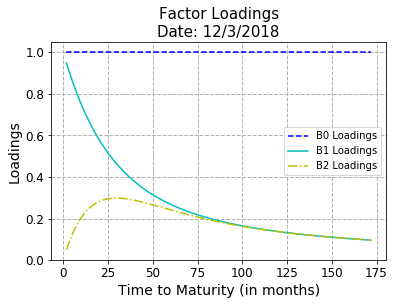

In [21]:
b0_loading, b1_loading, b2_loading = factor_loading(curve_points)

plt.figure()
plt.title('Factor Loadings\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Loadings')
plt.plot(curve_points, b0_loading, '--', color = 'b', label = 'B0 Loadings')
plt.plot(curve_points, b1_loading, '-', color = 'c', label="B1 Loadings")
plt.plot(curve_points, b2_loading, '-.', color = 'y', label="B2 Loadings")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

In [22]:
def residual(beta_, time_array, yields_):
    errors = []
    c_index = 0
    for i in yields_:
        errors.append(NS_yield(time_array[c_index], beta_) - i)
        c_index += 1
    return np.array(errors)

In [23]:
residual(beta, time_T, yields)

array([ 0.10400609,  0.03385846, -0.17542215, -0.25322635, -0.56295078,
       -0.63911151, -0.83482924, -0.98851052, -1.11047629, -1.21152484,
       -1.3387502 , -1.58161787])

In [24]:
res = least_squares(residual, beta, args = (time_T, yields))
optimum_beta = res.x
print('beta values: ', optimum_beta)
print('cost: ', res.cost)

beta values:  [ 2.97815864 -1.0071718  -1.67936121]
cost:  0.005538233212323534


In [25]:
residual(optimum_beta, time_T, yields)

array([ 0.03433988, -0.03661449, -0.04904668, -0.01269987,  0.03030292,
        0.03867799,  0.02255036,  0.01461636,  0.01039565,  0.0047213 ,
       -0.00533462, -0.05190882])

In [26]:
import statsmodels.api as sm

beta_sm = [1, 1, 1]
level_factor_sm =  np.ones(time_T.size)
slope_factor_sm = (1 - np.exp((-1)*lamda*time_T))/(lamda*time_T)
curvature_factor_sm = (1 - np.exp((-1)*lamda*time_T))/(lamda*time_T) - np.exp((-1)*lamda*time_T)
X = np.column_stack((level_factor_sm, slope_factor_sm, curvature_factor_sm))

model = sm.OLS(yields, X)
results = model.fit()
print('beta values: ', results.params)
print()
print(results.summary())

beta values:  [ 2.97815864 -1.0071718  -1.67936121]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     371.8
Date:                Sun, 16 Jun 2019   Prob (F-statistic):           2.24e-09
Time:                        22:02:45   Log-Likelihood:                 24.900
No. Observations:                  12   AIC:                            -43.80
Df Residuals:                       9   BIC:                            -42.34
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


In [27]:
np.round(NS_yield(time_T, optimum_beta), 3)

array([1.926, 1.879, 1.951, 2.006, 2.192, 2.239, 2.339, 2.421, 2.487,
       2.542, 2.609, 2.721])

In [28]:
yields

array([1.892, 1.916, 2.   , 2.019, 2.162, 2.2  , 2.316, 2.406, 2.477,
       2.537, 2.614, 2.773])

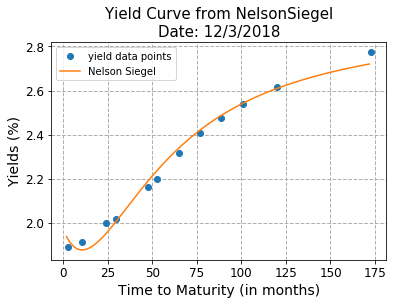

In [29]:
plt.figure()
plt.title('Yield Curve from NelsonSiegel\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(time_T, yields, 'o', label = 'yield data points')
plt.plot(curve_points, NS_yield(curve_points, optimum_beta), label="Nelson Siegel")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

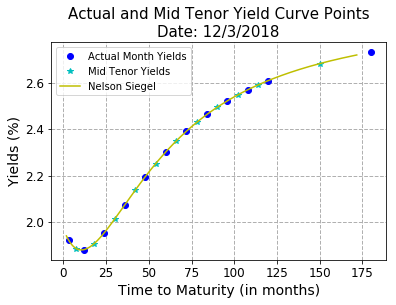

In [30]:
tenors = np.array([3/12*12, 1*12, 24, 3*12, 4*12, 5*12, 6*12, 7*12, 8*12, 9*12, 10*12, 15*12])
maturities_btw_each_tenors = np.array([7.5, 1.5*12, 2.5*12, 3.5*12, 4.5*12, 5.5*12, 6.5*12, 7.5*12, 8.5*12, 9.5*12, 12.5*12])

plt.figure()
plt.title('Actual and Mid Tenor Yield Curve Points\nDate: 12/3/2018', fontsize = 15)
plt.xlabel('Time to Maturity (in months)')
plt.ylabel('Yields (%)')
plt.plot(tenors, NS_yield(tenors, optimum_beta), 'o', color = 'b', label = 'Actual Month Yields')
plt.plot(maturities_btw_each_tenors, NS_yield(maturities_btw_each_tenors, optimum_beta), '*', color = 'c', label="Mid Tenor Yields")
plt.plot(curve_points, NS_yield(curve_points, optimum_beta), color = 'y', label="Nelson Siegel")
plt.grid(linestyle = '--', linewidth = 1)
plt.legend()
plt.show()

In [31]:
yield_values_for_each_tenors = pd.DataFrame({'Tenors (months)': tenors, 'Actual Month Yields': NS_yield(tenors, optimum_beta)})
yield_values_for_mid_tenors = pd.DataFrame({'Mid Tenors (months)': maturities_btw_each_tenors, 'Mid Tenor Yields': NS_yield(maturities_btw_each_tenors, optimum_beta)})

In [32]:
yield_values_for_each_tenors.join(yield_values_for_mid_tenors)

,Tenors (months),Actual Month Yields,Mid Tenors (months),Mid Tenor Yields
0,3.0,1.921942,7.5,1.885321
1,12.0,1.880675,18.0,1.906647
2,24.0,1.954212,30.0,2.012469
3,36.0,2.074604,42.0,2.136498
4,48.0,2.195779,54.0,2.251200
5,60.0,2.302222,66.0,2.348732
6,72.0,2.390874,78.0,2.428925
7,84.0,2.463228,90.0,2.494146
8,96.0,2.522034,102.0,2.547228
9,108.0,2.570034,114.0,2.590728


In [33]:
def BondPrice_calculation(coupons_, coupon_schedule_all_bonds_, BBG_prices, yields_, time_to_maturity, date_today_):
    All_Bond_Prices = []
    c_index = 0
    for i in coupon_schedule_all_bonds_:
        estimated_bond_price = 0
        for j in i:
            time_ = np.round(((j - datetime.strptime(date_today_, '%m/%d/%y')).days)*12/365, 3)
            estimated_bond_price += (coupons_[c_index]*0.5)/np.power(1 + 0.01*NS_yield(time_, optimum_beta), time_/12)
        
        estimated_bond_price += 100/np.power(1 + 0.01*NS_yield(time_, optimum_beta), time_/12)
        All_Bond_Prices.append(estimated_bond_price)
        c_index += 1
        
    results_DF = pd.DataFrame(index = data.ix[:, 6])
    results_DF.index.name = 'Bonds, ' + date_today_
    results_DF['BBG Prices'] = BBG_prices
    results_DF['Estimated Prices(NS)'] = All_Bond_Prices
    results_DF['BBG Yields'] = yields_
    results_DF['NS Yields'] = NS_yield(time_to_maturity, optimum_beta)
    results_DF['Price Error'] = results_DF['Estimated Prices(NS)'] - results_DF['BBG Prices']
    
    return results_DF

In [34]:
BondPrice_calculation(coupons, coupon_schedule_all_bonds, prices_data, yields, time_T, date_today)

,BBG Prices,Estimated Prices(NS),BBG Yields,NS Yields,Price Error
"Bonds, 12/03/18",,,,,
ACTB 0 02/22/19 Corp,99.587,99.577474,1.892,1.926340,-0.009526
ACGB 2 ¾ 10/21/19 Corp,100.720,101.088627,1.916,1.879386,0.368627
ACGB 1 ¾ 11/21/20 Corp,99.521,99.685740,2.000,1.950953,0.164740
ACGB 5 ¾ 05/15/21 Corp,108.856,109.231113,2.019,2.006300,0.375113
ACGB 2 ¼ 11/21/22 Corp,100.331,100.356209,2.162,2.192303,0.025209
ACGB 5 ½ 04/21/23 Corp,113.695,114.319828,2.200,2.238678,0.624828
ACGB 2 ¾ 04/21/24 Corp,102.180,102.522257,2.316,2.338550,0.342257
ACGB 3 ¼ 04/21/25 Corp,104.958,105.460832,2.406,2.420616,0.502832
ACGB 4 ¼ 04/21/26 Corp,111.886,112.638835,2.477,2.487396,0.752835


			********  RESULTS FOR DATE: 12/1/18  ********
			beta values:  [ 2.947776   -0.97369265 -1.65901314]
			cost:  0.005619091227980096


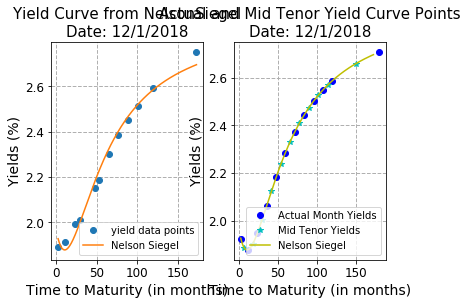

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.923814                7.5          1.885283
1            12.0             1.878716               18.0          1.902209
2            24.0             1.947459               30.0          2.003600
3            36.0             2.063832               42.0          2.124026
4            48.0             2.181800               54.0          2.235890
5            60.0             2.285735               66.0          2.331206
6            72.0             2.372428               78.0          2.409665
7            84.0             2.443245               90.0          2.473518
8            96.0             2.500831              102.0          2.525508
9           108.0             2.547848              114.0          2.568121
10          120.0             2.586566              150.0          2.657894
11          180.0             2.706057                NaN               NaN

           

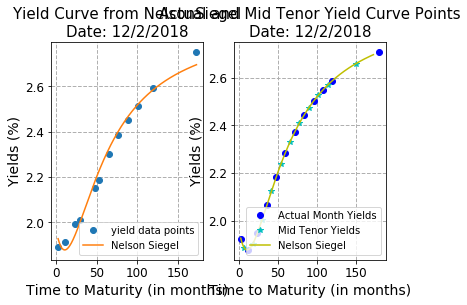

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.923394                7.5          1.885126
1            12.0             1.878743               18.0          1.902393
2            24.0             1.947731               30.0          2.003917
3            36.0             2.064164               42.0          2.124356
4            48.0             2.182117               54.0          2.236187
5            60.0             2.286010               66.0          2.331458
6            72.0             2.372658               78.0          2.409872
7            84.0             2.443431               90.0          2.473685
8            96.0             2.500979              102.0          2.525640
9           108.0             2.547965              114.0          2.568224
10          120.0             2.586656              150.0          2.657933
11          180.0             2.706062                NaN               NaN

           

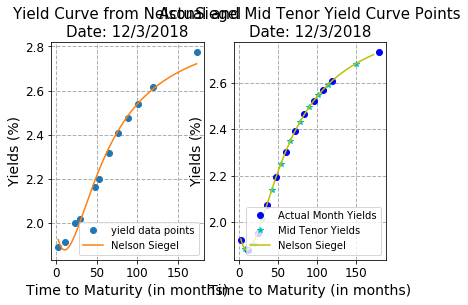

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.921942                7.5          1.885321
1            12.0             1.880675               18.0          1.906647
2            24.0             1.954212               30.0          2.012469
3            36.0             2.074604               42.0          2.136498
4            48.0             2.195779               54.0          2.251200
5            60.0             2.302222               66.0          2.348732
6            72.0             2.390874               78.0          2.428925
7            84.0             2.463228               90.0          2.494146
8            96.0             2.522034              102.0          2.547228
9           108.0             2.570034              114.0          2.590728
10          120.0             2.609554              150.0          2.682348
11          180.0             2.731497                NaN               NaN

           

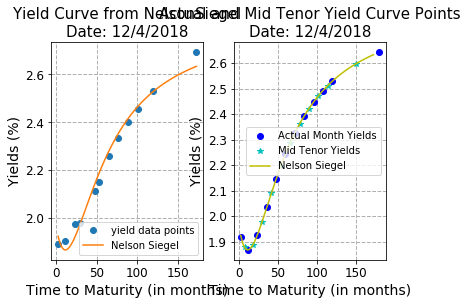

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.919684                7.5          1.878008
1            12.0             1.867945               18.0          1.886592
2            24.0             1.927073               30.0          1.978706
3            36.0             2.034777               42.0          2.091193
4            48.0             2.145571               54.0          2.196625
5            60.0             2.243768               66.0          2.286838
6            72.0             2.325926               78.0          2.361264
7            84.0             2.393153               90.0          2.421915
8            96.0             2.447874              102.0          2.471335
9           108.0             2.492580              114.0          2.511862
10          120.0             2.529407              150.0          2.597272
11          180.0             2.643105                NaN               NaN

           

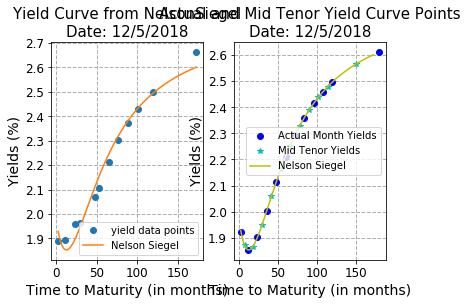

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.922002                7.5          1.870714
1            12.0             1.853473               18.0          1.865325
2            24.0             1.901261               30.0          1.949887
3            36.0             2.004000               42.0          2.059168
4            48.0             2.112778               54.0          2.163385
5            60.0             2.210294               66.0          2.253269
6            72.0             2.292351               78.0          2.327739
7            84.0             2.359710               90.0          2.388573
8            96.0             2.414642              102.0          2.438215
9           108.0             2.459570              114.0          2.478958
10          120.0             2.496604              150.0          2.564890
11          180.0             2.611020                NaN               NaN

           

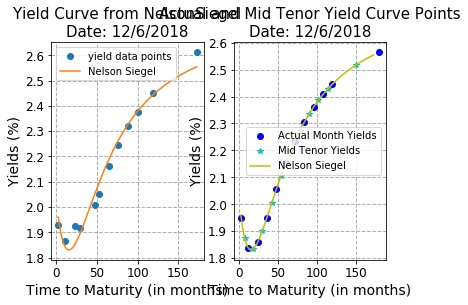

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.950208                7.5          1.873822
1            12.0             1.838205               18.0          1.833150
2            24.0             1.858266               30.0          1.900165
3            36.0             1.950287               42.0          2.003274
4            48.0             2.055882               54.0          2.106245
5            60.0             2.153380               66.0          2.196863
6            72.0             2.236611               78.0          2.272739
7            84.0             2.305475               90.0          2.335095
8            96.0             2.361892              102.0          2.386157
9           108.0             2.408161              114.0          2.428155
10          120.0             2.446363              150.0          2.516894
11          180.0             2.564577                NaN               NaN

           

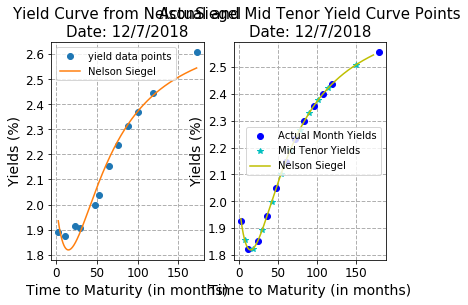

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.924833                7.5          1.854785
1            12.0             1.823744               18.0          1.822811
2            24.0             1.850473               30.0          1.893873
3            36.0             1.944804               42.0          1.998152
4            48.0             2.050836               54.0          2.101098
5            60.0             2.148028               66.0          2.191249
6            72.0             2.230709               78.0          2.266542
7            84.0             2.298988               90.0          2.328329
8            96.0             2.354865              102.0          2.378884
9           108.0             2.400660              114.0          2.420443
10          120.0             2.438457              150.0          2.508218
11          180.0             2.555372                NaN               NaN

           

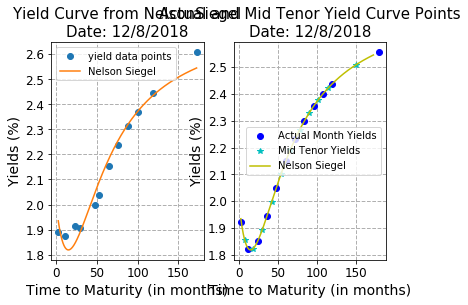

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.924149                7.5          1.854425
1            12.0             1.823614               18.0          1.822883
2            24.0             1.850667               30.0          1.894132
3            36.0             1.945095               42.0          1.998451
4            48.0             2.051130               54.0          2.101378
5            60.0             2.148290               66.0          2.191491
6            72.0             2.230930               78.0          2.266743
7            84.0             2.299169               90.0          2.328492
8            96.0             2.355009              102.0          2.379013
9           108.0             2.400774              114.0          2.420543
10          120.0             2.438545              150.0          2.508256
11          180.0             2.555376                NaN               NaN

           

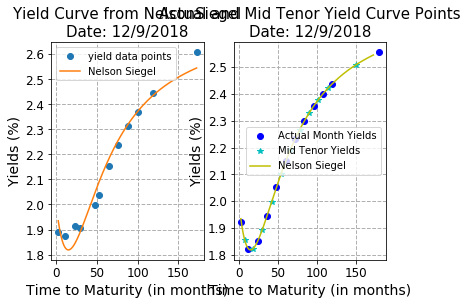

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.923468                7.5          1.854066
1            12.0             1.823484               18.0          1.822955
2            24.0             1.850858               30.0          1.894390
3            36.0             1.945384               42.0          1.998749
4            48.0             2.051422               54.0          2.101657
5            60.0             2.148552               66.0          2.191733
6            72.0             2.231150               78.0          2.266943
7            84.0             2.299349               90.0          2.328654
8            96.0             2.355154              102.0          2.379142
9           108.0             2.400888              114.0          2.420644
10          120.0             2.438633              150.0          2.508295
11          180.0             2.555381                NaN               NaN

           

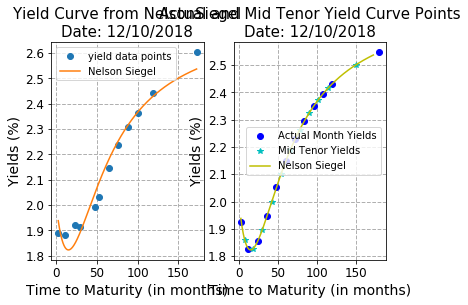

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.926077                7.5          1.857694
1            12.0             1.827520               18.0          1.826904
2            24.0             1.854280               30.0          1.897045
3            36.0             1.947163               42.0          1.999624
4            48.0             2.051410               54.0          2.100804
5            60.0             2.146915               66.0          2.189376
6            72.0             2.228138               78.0          2.263336
7            84.0             2.295205               90.0          2.324023
8            96.0             2.350085              102.0          2.373675
9           108.0             2.395061              114.0          2.414490
10          120.0             2.432181              150.0          2.500690
11          180.0             2.546998                NaN               NaN

           

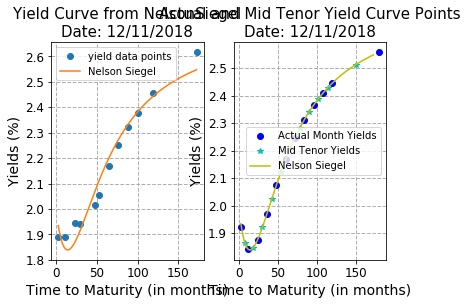

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.923715                7.5          1.864867
1            12.0             1.841292               18.0          1.846227
2            24.0             1.876621               30.0          1.920768
3            36.0             1.971230               42.0          2.023397
4            48.0             2.074517               54.0          2.123041
5            60.0             2.168192               66.0          2.209671
6            72.0             2.247471               78.0          2.281750
7            84.0             2.312755               90.0          2.340772
8            96.0             2.366094              102.0          2.389004
9           108.0             2.409767              114.0          2.428624
10          120.0             2.445791              150.0          2.512248
11          180.0             2.557157                NaN               NaN

           

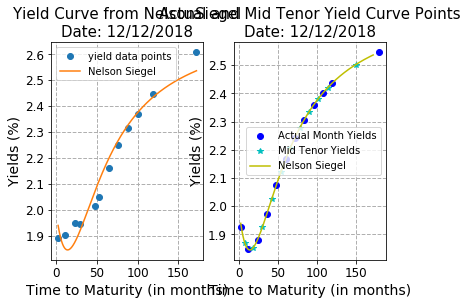

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.927391                7.5          1.869744
1            12.0             1.846610               18.0          1.851350
2            24.0             1.881007               30.0          1.924127
3            36.0             1.973433               42.0          2.024415
4            48.0             2.074379               54.0          2.121810
5            60.0             2.165945               66.0          2.206493
6            72.0             2.243445               78.0          2.276956
7            84.0             2.307267               90.0          2.334657
8            96.0             2.359412              102.0          2.381810
9           108.0             2.402108              114.0          2.420544
10          120.0             2.437327              150.0          2.502299
11          180.0             2.546205                NaN               NaN

           

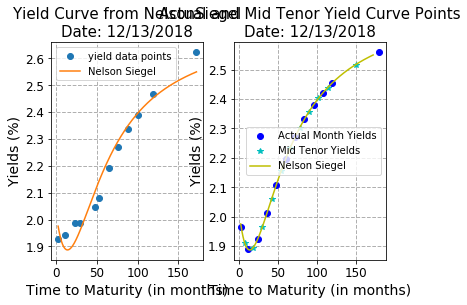

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.963896                7.5          1.909974
1            12.0             1.888733               18.0          1.894078
2            24.0             1.922959               30.0          1.964518
3            36.0             2.011861               42.0          2.060720
4            48.0             2.108549               54.0          2.153918
5            60.0             2.196114               66.0          2.234866
6            72.0             2.270171               78.0          2.302182
7            84.0             2.331132               90.0          2.357289
8            96.0             2.380927              102.0          2.402313
9           108.0             2.421694              114.0          2.439294
10          120.0             2.455317              150.0          2.517342
11          180.0             2.559255                NaN               NaN

           

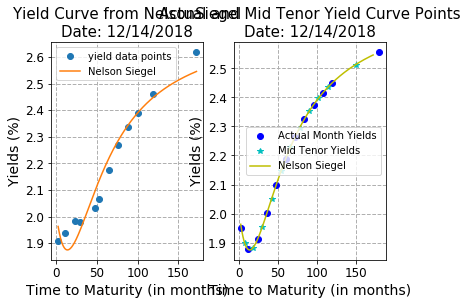

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.951088                7.5          1.897391
1            12.0             1.876510               18.0          1.882455
2            24.0             1.911993               30.0          1.954215
3            36.0             2.002196               42.0          2.051650
4            48.0             2.100025               54.0          2.145891
5            60.0             2.188533               66.0          2.227685
6            72.0             2.263349               78.0          2.295680
7            84.0             2.324917               90.0          2.351331
8            96.0             2.375200              102.0          2.396794
9           108.0             2.416362              114.0          2.434132
10          120.0             2.450310              150.0          2.512930
11          180.0             2.555243                NaN               NaN

           

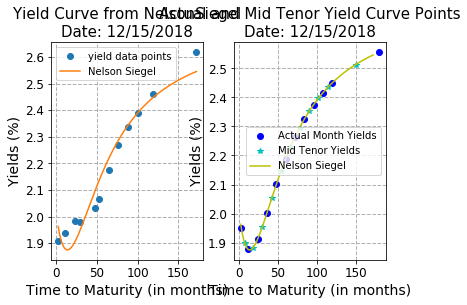

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.950549                7.5          1.897125
1            12.0             1.876439               18.0          1.882553
2            24.0             1.912190               30.0          1.954464
3            36.0             2.002468               42.0          2.051927
4            48.0             2.100295               54.0          2.146146
5            60.0             2.188771               66.0          2.227904
6            72.0             2.263548               78.0          2.295861
7            84.0             2.325079               90.0          2.351476
8            96.0             2.375329              102.0          2.396908
9           108.0             2.416463              114.0          2.434221
10          120.0             2.450387              150.0          2.512962
11          180.0             2.555244                NaN               NaN

           

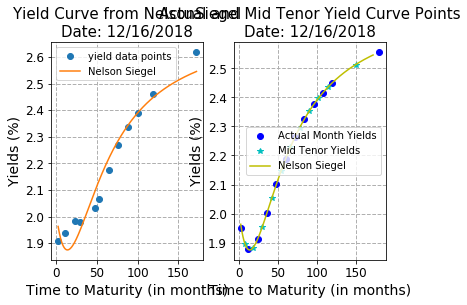

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.950030                7.5          1.896872
1            12.0             1.876373               18.0          1.882651
2            24.0             1.912385               30.0          1.954711
3            36.0             2.002738               42.0          2.052200
4            48.0             2.100561               54.0          2.146399
5            60.0             2.189007               66.0          2.228121
6            72.0             2.263746               78.0          2.296040
7            84.0             2.325241               90.0          2.351621
8            96.0             2.375459              102.0          2.397024
9           108.0             2.416565              114.0          2.434311
10          120.0             2.450466              150.0          2.512997
11          180.0             2.555249                NaN               NaN

           

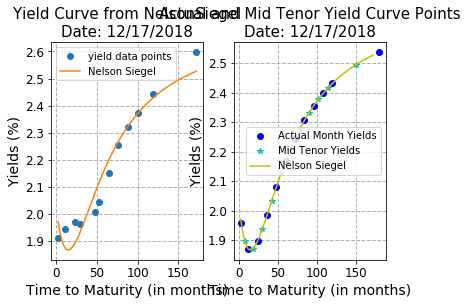

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.956861                7.5          1.896584
1            12.0             1.870777               18.0          1.872038
2            24.0             1.898424               30.0          1.938545
3            36.0             1.985142               42.0          2.033701
4            48.0             2.081512               54.0          2.127037
5            60.0             2.169487               66.0          2.208545
6            72.0             2.244178               78.0          2.276520
7            84.0             2.305793               90.0          2.332257
8            96.0             2.356184              102.0          2.377839
9           108.0             2.397469              114.0          2.415300
10          120.0             2.431535              150.0          2.494399
11          180.0             2.536886                NaN               NaN

           

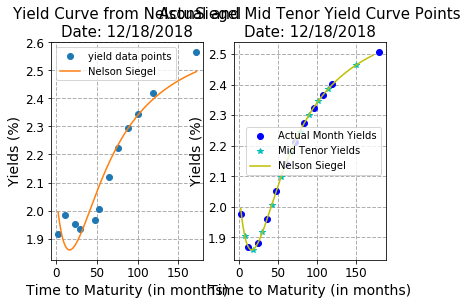

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.975791                7.5          1.903395
1            12.0             1.868378               18.0          1.860708
2            24.0             1.880909               30.0          1.916749
3            36.0             1.960389               42.0          2.006908
4            48.0             2.053314               54.0          2.097875
5            60.0             2.139666               66.0          2.178275
6            72.0             2.213606               78.0          2.245745
7            84.0             2.274883               90.0          2.301261
8            96.0             2.325133              102.0          2.346756
9           108.0             2.366367              114.0          2.384190
10          120.0             2.400424              150.0          2.463318
11          180.0             2.505844                NaN               NaN

           

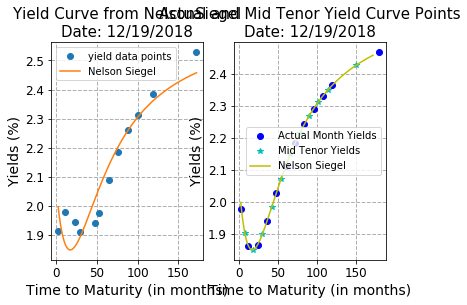

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.977198                7.5          1.900442
1            12.0             1.861572               18.0          1.849457
2            24.0             1.865892               30.0          1.898538
3            36.0             1.939462               42.0          1.983665
4            48.0             2.028090               54.0          2.070948
5            60.0             2.111270               66.0          2.148606
6            72.0             2.182827               78.0          2.213995
7            84.0             2.242278               90.0          2.267900
8            96.0             2.291101              102.0          2.312123
9           108.0             2.331198              114.0          2.348536
10          120.0             2.364331              150.0          2.425547
11          180.0             2.466948                NaN               NaN

           

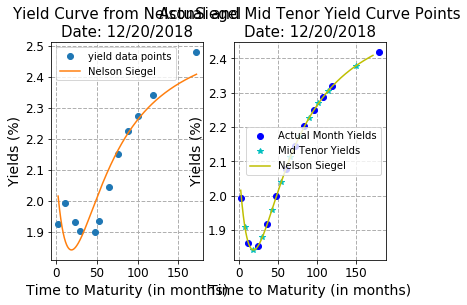

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.992883                7.5          1.907896
1            12.0             1.862033               18.0          1.842163
2            24.0             1.852285               30.0          1.879755
3            36.0             1.916405               42.0          1.957053
4            48.0             1.998499               54.0          2.038842
5            60.0             2.077026               66.0          2.112531
6            72.0             2.145174               78.0          2.174971
7            84.0             2.202057               90.0          2.226626
8            96.0             2.248895              102.0          2.269089
9           108.0             2.287422              114.0          2.304095
10          120.0             2.319289              150.0          2.378207
11          180.0             2.418071                NaN               NaN

           

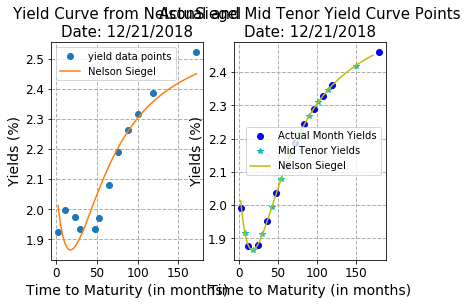

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.990969                7.5          1.916026
1            12.0             1.877846               18.0          1.865495
2            24.0             1.880888               30.0          1.912061
3            36.0             1.951316               42.0          1.993804
4            48.0             2.036552               54.0          2.077822
5            60.0             2.116668               66.0          2.152650
6            72.0             2.185637               78.0          2.215687
7            84.0             2.242960               90.0          2.267668
8            96.0             2.290045              102.0          2.310321
9           108.0             2.328719              114.0          2.345443
10          120.0             2.360679              150.0          2.419731
11          180.0             2.459670                NaN               NaN

           

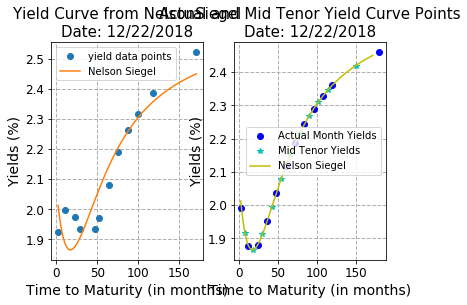

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.990256                7.5          1.915621
1            12.0             1.877661               18.0          1.865506
2            24.0             1.881018               30.0          1.912258
3            36.0             1.951548               42.0          1.994047
4            48.0             2.036795               54.0          2.078055
5            60.0             2.116887               66.0          2.152852
6            72.0             2.185822               78.0          2.215855
7            84.0             2.243111               90.0          2.267804
8            96.0             2.290165              102.0          2.310428
9           108.0             2.328813              114.0          2.345525
10          120.0             2.360751              150.0          2.419760
11          180.0             2.459669                NaN               NaN

           

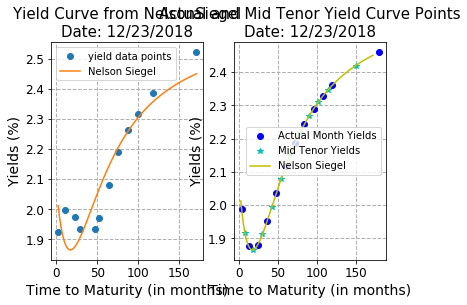

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.989545                7.5          1.915218
1            12.0             1.877478               18.0          1.865519
2            24.0             1.881149               30.0          1.912456
3            36.0             1.951779               42.0          1.994291
4            48.0             2.037037               54.0          2.078288
5            60.0             2.117106               66.0          2.153055
6            72.0             2.186008               78.0          2.216023
7            84.0             2.243262               90.0          2.267939
8            96.0             2.290286              102.0          2.310534
9           108.0             2.328907              114.0          2.345607
10          120.0             2.360822              150.0          2.419788
11          180.0             2.459668                NaN               NaN

           

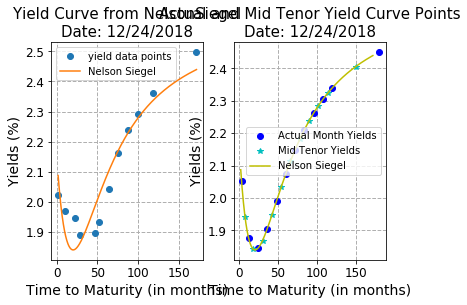

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.053301                7.5          1.941724
1            12.0             1.877605               18.0          1.842596
2            24.0             1.844721               30.0          1.868791
3            36.0             1.904932               42.0          1.946830
4            48.0             1.990540               54.0          2.033677
5            60.0             2.074875               66.0          2.113424
6            72.0             2.149024               78.0          2.181630
7            84.0             2.211342               90.0          2.238344
8            96.0             2.262855              102.0          2.285105
9           108.0             2.305322              114.0          2.323720
10          120.0             2.340495              150.0          2.405597
11          180.0             2.449673                NaN               NaN

           

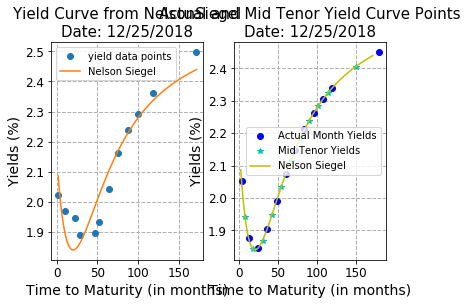

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.052273                7.5          1.941092
1            12.0             1.877260               18.0          1.842510
2            24.0             1.844795               30.0          1.868960
3            36.0             1.905153               42.0          1.947075
4            48.0             1.990791               54.0          2.033923
5            60.0             2.075109               66.0          2.113642
6            72.0             2.149225               78.0          2.181813
7            84.0             2.211508               90.0          2.238493
8            96.0             2.262988              102.0          2.285223
9           108.0             2.305427              114.0          2.323812
10          120.0             2.340575              150.0          2.405631
11          180.0             2.449674                NaN               NaN

           

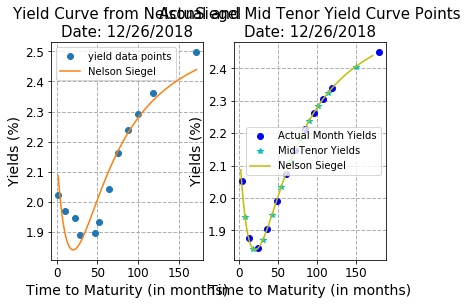

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.051248                7.5          1.940463
1            12.0             1.876916               18.0          1.842423
2            24.0             1.844868               30.0          1.869128
3            36.0             1.905372               42.0          1.947318
4            48.0             1.991040               54.0          2.034167
5            60.0             2.075342               66.0          2.113859
6            72.0             2.149425               78.0          2.181996
7            84.0             2.211673               90.0          2.238641
8            96.0             2.263120              102.0          2.285341
9           108.0             2.305531              114.0          2.323903
10          120.0             2.340655              150.0          2.405664
11          180.0             2.449675                NaN               NaN

           

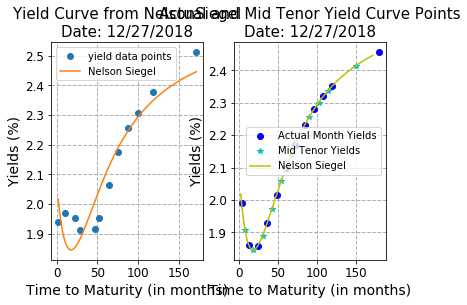

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.989424                7.5          1.906214
1            12.0             1.862529               18.0          1.845860
2            24.0             1.859254               30.0          1.889893
3            36.0             1.929514               42.0          1.972891
4            48.0             2.016811               54.0          2.059379
5            60.0             2.099552               66.0          2.136832
6            72.0             2.171056               78.0          2.202264
7            84.0             2.230609               90.0          2.256303
8            96.0             2.279583              102.0          2.300684
9           108.0             2.319836              114.0          2.337250
10          120.0             2.353116              150.0          2.414626
11          180.0             2.456235                NaN               NaN

           

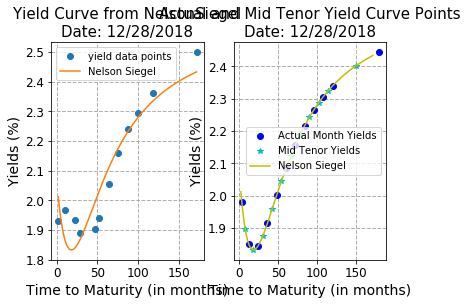

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.981832                7.5          1.896201
1            12.0             1.850797               18.0          1.832621
2            24.0             1.845127               30.0          1.875284
3            36.0             1.914687               42.0          1.958013
4            48.0             2.001986               54.0          2.044667
5            60.0             2.084986               66.0          2.122428
6            72.0             2.156817               78.0          2.188187
7            84.0             2.216687               90.0          2.242528
8            96.0             2.265943              102.0          2.287171
9           108.0             2.306440              114.0          2.323960
10          120.0             2.339925              150.0          2.401822
11          180.0             2.443696                NaN               NaN

           

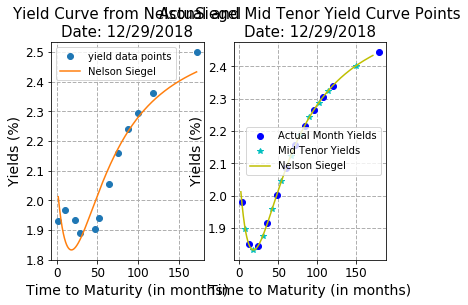

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.981024                7.5          1.895730
1            12.0             1.850569               18.0          1.832610
2            24.0             1.845248               30.0          1.875481
3            36.0             1.914922               42.0          1.958264
4            48.0             2.002237               54.0          2.044909
5            60.0             2.085215               66.0          2.122639
6            72.0             2.157010               78.0          2.188362
7            84.0             2.216845               90.0          2.242669
8            96.0             2.266069              102.0          2.287283
9           108.0             2.306537              114.0          2.324045
10          120.0             2.339999              150.0          2.401850
11          180.0             2.443693                NaN               NaN

           

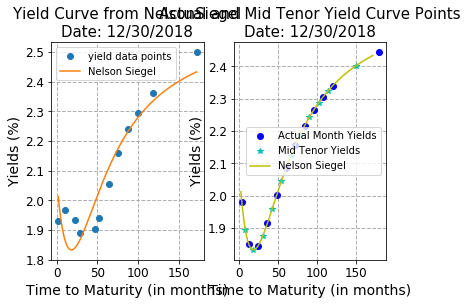

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             1.980220                7.5          1.895262
1            12.0             1.850342               18.0          1.832598
2            24.0             1.845367               30.0          1.875676
3            36.0             1.915156               42.0          1.958513
4            48.0             2.002487               54.0          2.045150
5            60.0             2.085442               66.0          2.122850
6            72.0             2.157204               78.0          2.188538
7            84.0             2.217004               90.0          2.242811
8            96.0             2.266196              102.0          2.287395
9           108.0             2.306636              114.0          2.324132
10          120.0             2.340074              150.0          2.401881
11          180.0             2.443693                NaN               NaN

           

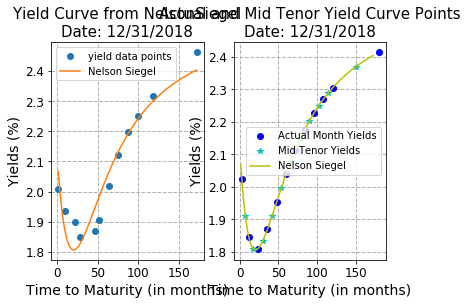

    Tenors(mnths)  Actual Month Yields  Mid Tenors(mnths)  Mid Tenor Yields
0             3.0             2.024622                7.5          1.910967
1            12.0             1.845320               18.0          1.808898
2            24.0             1.810109               30.0          1.833604
3            36.0             1.869396               42.0          1.911097
4            48.0             1.954707               54.0          1.997809
5            60.0             2.039013               66.0          2.077591
6            72.0             2.113236               78.0          2.145893
7            84.0             2.175660               90.0          2.202716
8            96.0             2.227280              102.0          2.249581
9           108.0             2.269846              114.0          2.288289
10          120.0             2.305106              150.0          2.370375
11          180.0             2.414567                NaN               NaN

           

In [35]:
days_DEC2018 = range(1,32)
Dec_dates = []
Dec_beta_all_days = []

for i in days_DEC2018:
    Dec_dates.append('12/' + str(i) + '/2018')
    print('\t\t\t********  RESULTS FOR DATE: ' + '12/' + str(i) + '/18  ********')
    Dec_data = pd.read_excel('FIS_Project_Data/' + str(i) + '.xlsx')
    Dec_data = Dec_data[Dec_data.iloc[:, 6] != 'Same']
    Dec_data.index = range(12)
    
    Dec_date_today = '12/' + str(i) + '/18'
    Dec_time_T, Dec_yields, Dec_coupon_schedule_all_bonds, Dec_prices_data, Dec_coupons = Get_Input_Data(Dec_data, Dec_date_today)
    
    curve_points = np.linspace(min(Dec_time_T), max(Dec_time_T), 1000)
    
    Dec_b0 = 1
    Dec_b1 = 1
    Dec_b2 = 1
    Dec_beta = [Dec_b0, Dec_b1, Dec_b2]

    res = least_squares(residual, Dec_beta, args = (Dec_time_T, Dec_yields))
    Dec_optimum_beta = res.x
    print('\t\t\tbeta values: ', Dec_optimum_beta)
    print('\t\t\tcost: ', res.cost)
    Dec_beta_all_days.append(Dec_optimum_beta)
    
    plt.subplot(1,2,1)
    plt.title('Yield Curve from NelsonSiegel\nDate: 12/' + str(i) + '/2018', fontsize = 15)
    plt.xlabel('Time to Maturity (in months)')
    plt.ylabel('Yields (%)')
    plt.plot(Dec_time_T, Dec_yields, 'o', label = 'yield data points')
    plt.plot(curve_points, NS_yield(curve_points, Dec_optimum_beta), label="Nelson Siegel")
    plt.grid(linestyle = '--', linewidth = 1)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Actual and Mid Tenor Yield Curve Points\nDate: 12/' + str(i) + '/2018', fontsize = 15)
    plt.xlabel('Time to Maturity (in months)')
    plt.ylabel('Yields (%)')
    plt.plot(tenors, NS_yield(tenors, Dec_optimum_beta), 'o', color = 'b', label = 'Actual Month Yields')
    plt.plot(maturities_btw_each_tenors, NS_yield(maturities_btw_each_tenors, Dec_optimum_beta), '*', color = 'c', label="Mid Tenor Yields")
    plt.plot(curve_points, NS_yield(curve_points, Dec_optimum_beta), color = 'y', label="Nelson Siegel")
    plt.grid(linestyle = '--', linewidth = 1)
    plt.legend()
    plt.show()
    
    yield_values_for_each_tenors = pd.DataFrame({'Tenors(mnths)': tenors, 'Actual Month Yields': NS_yield(tenors, Dec_optimum_beta)})
    yield_values_for_mid_tenors = pd.DataFrame({'Mid Tenors(mnths)': maturities_btw_each_tenors, 'Mid Tenor Yields': NS_yield(maturities_btw_each_tenors, Dec_optimum_beta)})

    print(yield_values_for_each_tenors.join(yield_values_for_mid_tenors))
    print()
    print(BondPrice_calculation(Dec_coupons, Dec_coupon_schedule_all_bonds, Dec_prices_data, Dec_yields, Dec_time_T, Dec_date_today).ix[:, [0, 1, 4]])
    print('\n')

In [36]:
Dec_beta = pd.DataFrame(Dec_beta_all_days, columns = ['Level B0', 'Slope B1', 'Curvature B2'], index = Dec_dates)
Dec_beta

,Level B0,Slope B1,Curvature B2
12/1/2018,2.947776,-0.973693,-1.659013
12/2/2018,2.947608,-0.974176,-1.656641
12/3/2018,2.978159,-1.007172,-1.679361
12/4/2018,2.873138,-0.901434,-1.604007
12/5/2018,2.842570,-0.860408,-1.661560
12/6/2018,2.803974,-0.772062,-1.835398
12/7/2018,2.792101,-0.791056,-1.787338
12/8/2018,2.791934,-0.791855,-1.784673
12/9/2018,2.791769,-0.792652,-1.782024
12/10/2018,2.779476,-0.778893,-1.753196


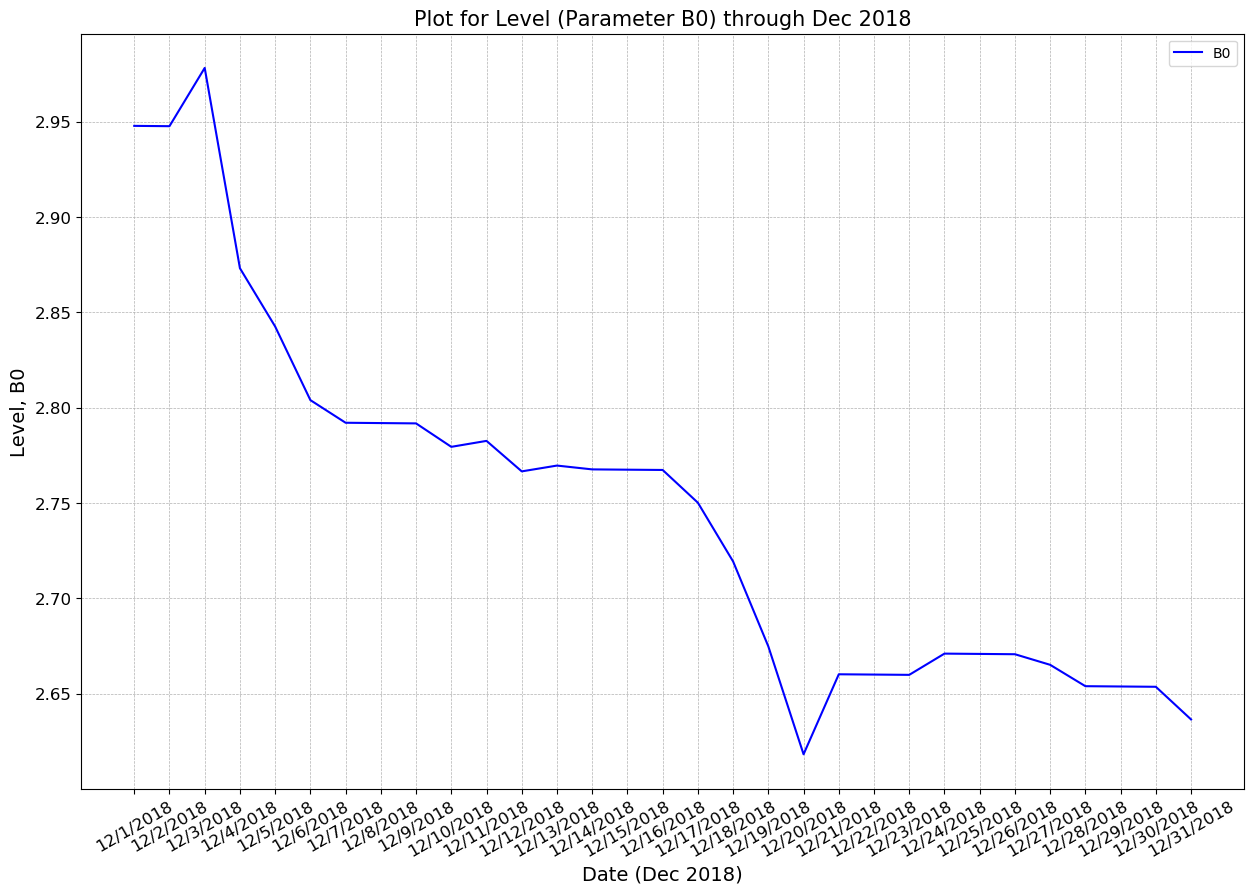

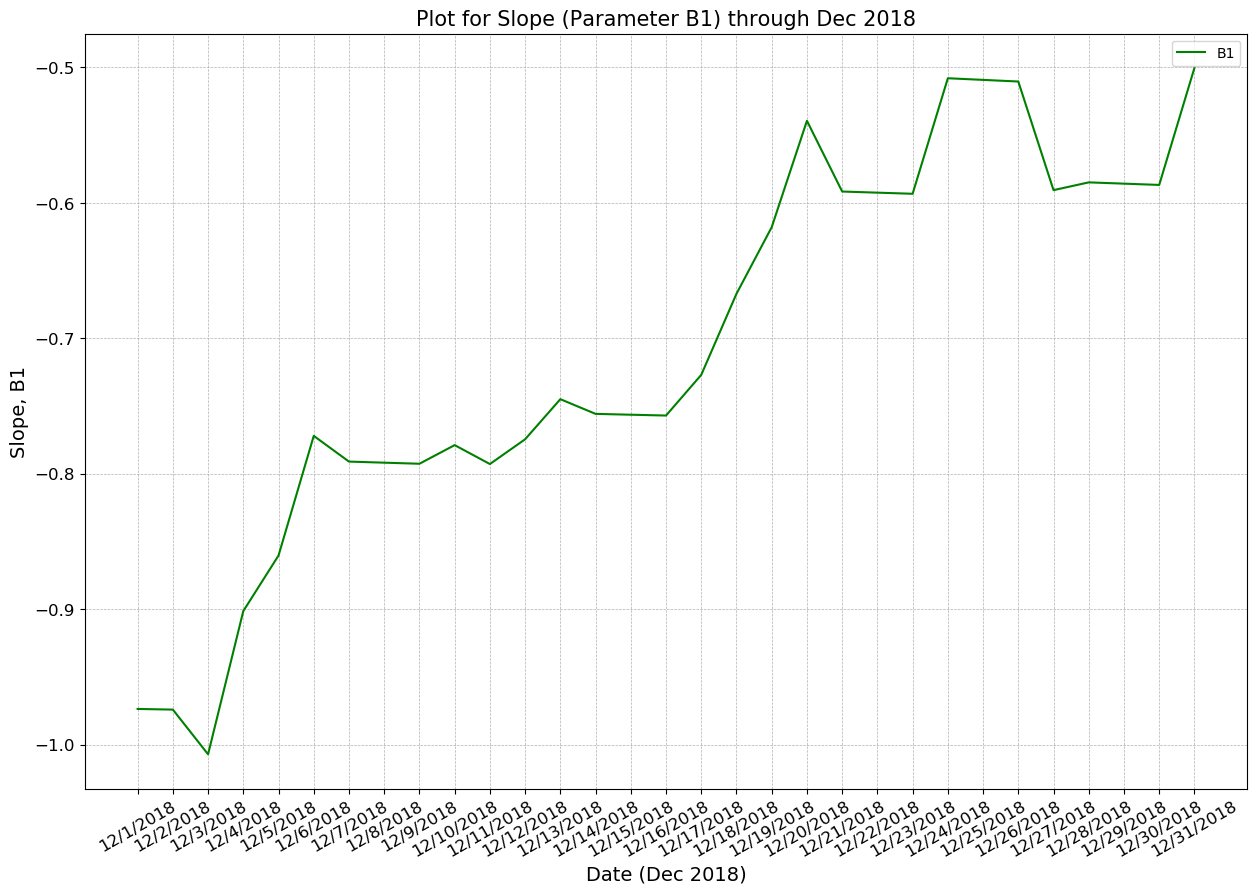

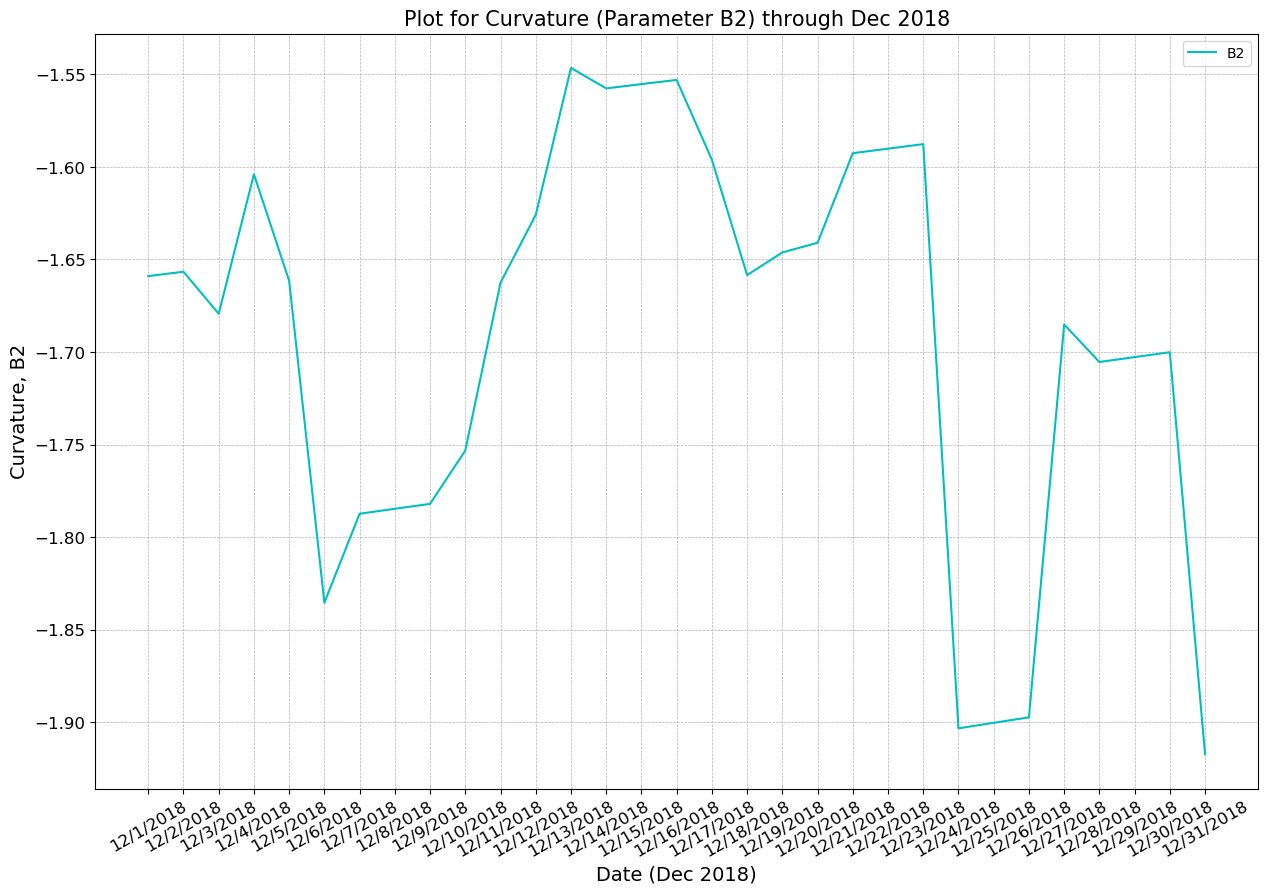

In [37]:
plt.figure(num= None, figsize= (15,10),dpi = 100, facecolor = 'w',edgecolor = 'k')
plt.title('Plot for Level (Parameter B0) through Dec 2018', fontsize = 15)
plt.xlabel('Date (Dec 2018)')
plt.ylabel('Level, B0')
plt.plot(Dec_beta.index, Dec_beta['Level B0'], color = 'b', label = 'B0')
plt.xticks(Dec_dates,rotation = 30)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

plt.figure(num= None, figsize= (15,10),dpi = 100, facecolor = 'w',edgecolor = 'k')
plt.title('Plot for Slope (Parameter B1) through Dec 2018', fontsize = 15)
plt.xlabel('Date (Dec 2018)')
plt.ylabel('Slope, B1')
plt.plot(Dec_beta.index, Dec_beta['Slope B1'], color = 'g', label = 'B1')
plt.xticks(Dec_dates,rotation = 30)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

plt.figure(num= None, figsize= (15,10),dpi = 100, facecolor = 'w',edgecolor = 'k')
plt.title('Plot for Curvature (Parameter B2) through Dec 2018', fontsize = 15)
plt.xlabel('Date (Dec 2018)')
plt.ylabel('Curvature, B2')
plt.plot(Dec_beta.index, Dec_beta['Curvature B2'], color = 'c', label = 'B2')
plt.xticks(Dec_dates,rotation = 30)
plt.grid(linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()